<a href="https://colab.research.google.com/github/dileep9968/pytorch/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Get setup

In [ ]:
import torch
import torchvision

In [ ]:
try:
  from torchinfo import summary

except:
  print("[INFO] couldn't find torchinfo, installing it...")
  !pip install torchinfo
  from torchinfo import summary

try:
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  print("[INFO] couldn't find going_modular, installing it...")
  !git clone https://github.com/dileep9968/pytorch
  !mv pytorch/going_modular .
  !mv pytorch/helper_functions.py .
  !rm -rf pytorch
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] couldn't find torchinfo, installing it...
[INFO] couldn't find going_modular, installing it...
Cloning into 'pytorch'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 90 (delta 38), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 11.84 MiB | 6.40 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [ ]:
!ls going_modular

data_setup.py  model_builder.py  __pycache__  train.py
engine.py      predictions.py	 README.md    utils.py


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Getting data

In [ ]:
# Download pizz, steak, sushu images form github

data_20_percent_path = download_data(source='https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip',
                                     destination = 'pizza_steak_sushi_20_percent')

data_20_percent_path


[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [ ]:
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini Model deployment experiment outline

## #. Creating an effnetb2 features extractor

In [ ]:
#effnetb2

In [ ]:
# from torchinfo import summary
# summary(model =effnetb2,
#         input_size = (1,3,224,224),
#         col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
#         col_width=20,
#         row_settings = ['var_names'])

In [ ]:
### 3.1 Creating a function to make an EffnetB2 features extractor
from torch import nn
def create_effnetb2_model(num_classes:int = 3,
                          seed:int = 42,
                          ):
  set_seeds(seed = seed)
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnetb2_transforms = effnetb2_weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = effnetb2_weights)
  for param in model.parameters():
    param.requires_grad = False


  set_seeds()
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  )
  return model, effnetb2_transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42
                                                      )



Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 160MB/s]


### 3.2 Create DAtaloader for EffNetB2

In [ ]:
# Setup DataLoaders

from going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = effnetb2_transforms,
    batch_size = 32
)

In [ ]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [ ]:
### 3.3 Training EffNetB2 features extractor
from going_modular import engine
import os


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                             lr = 0.001)

set_seeds()
effnetb2_results = engine.train(model = effnetb2,
                            train_dataloader = train_dataloader_effnetb2,
                            test_dataloader = test_dataloader_effnetb2,
                            loss_fn = loss_fn,
                            optimizer = optimizer,
                            epochs = 10,
                            device = device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9681 | train_acc: 0.6062 | test_loss: 0.7254 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.6953 | train_acc: 0.8500 | test_loss: 0.5708 | test_acc: 0.9472
Epoch: 3 | train_loss: 0.5696 | train_acc: 0.9021 | test_loss: 0.4742 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4319 | train_acc: 0.9146 | test_loss: 0.4193 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4118 | train_acc: 0.9104 | test_loss: 0.3773 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4248 | train_acc: 0.8938 | test_loss: 0.3391 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4090 | train_acc: 0.8812 | test_loss: 0.3158 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3788 | train_acc: 0.9021 | test_loss: 0.3371 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3783 | train_acc: 0.9000 | test_loss: 0.3036 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3534 | train_acc: 0.8708 | test_loss: 0.2731 | test_acc: 0.9563


### 3.4 Inspection loss

In [ ]:
from helper_functions import plot_loss_curves


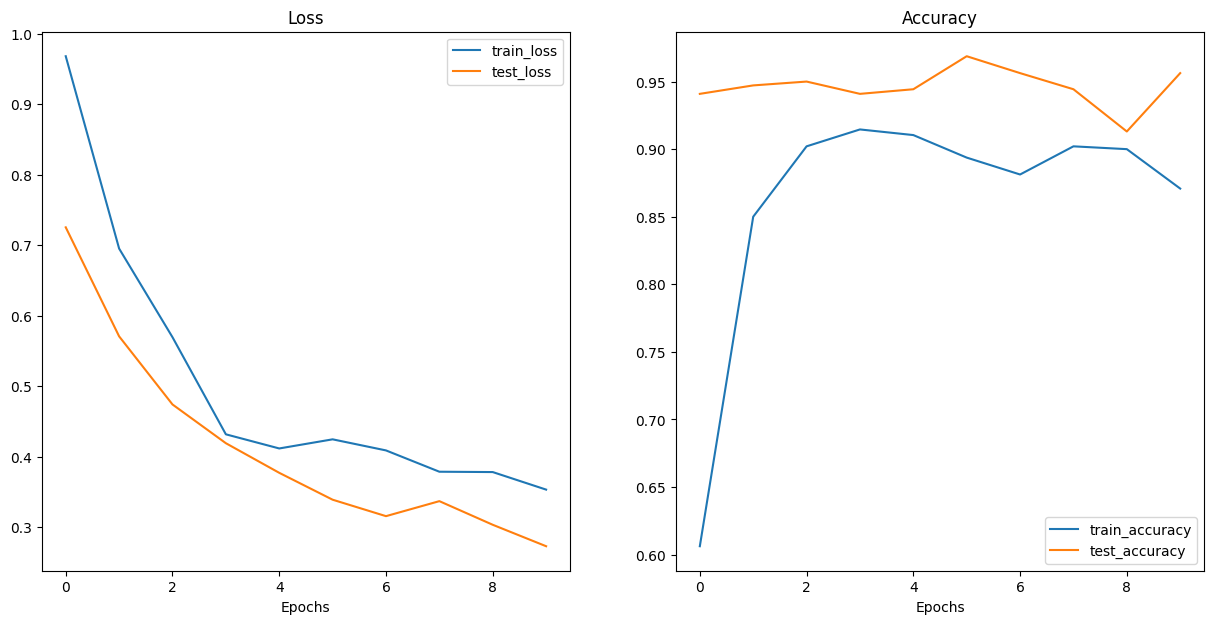

In [ ]:
plot_loss_curves(effnetb2_results)

### 3.5 Saving EffnetB2 Features extractor

In [ ]:
from going_modular import utils

# saving the model
utils.save_model(model = effnetb2,
                 target_dir = 'models',
                 model_name = '09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth')


[INFO] Saving model to: models/09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth


### e.6 Inspection the size of our effnetb2 features extractor

In [ ]:
from pathlib import Path

# GEt the model size in bytes

pretrained_effnetb2_model_size = Path('models/09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth').stat().st_size//(1024*1024)

print(f"Pretrained EffNetB2 model size: {pretrained_effnetb2_model_size} MB")


Pretrained EffNetB2 model size: 29 MB


### 3.7 Collect Effnetb2 featues extractor stats


In [ ]:
# count nuber of parameters in EffNetB2

effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [ ]:
# Create a dictionary  with effnetb2  statistic

effnetb2_stats = {
    "test_loss":effnetb2_results['test_loss'][-1],
    "test_acc":effnetb2_results['test_acc'][-1],
    "model_params":effnetb2_total_params,
    "model_size (MB)": pretrained_effnetb2_model_size
}

In [ ]:
effnetb2_stats

{'test_loss': 0.2731470137834549,
 'test_acc': 0.95625,
 'model_params': 7705221,
 'model_size (MB)': 29}

## 4. Creating a VIT Features Extractor

In [ ]:
vit = torchvision.models.vit_b_16()

vit.heads


Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  set_seeds()
  model.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes, bias=True)
  )
  return model, transforms

In [ ]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 157MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 4.1 Create DataLoader for ViT features extractor


In [ ]:
from going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = vit_transforms,
    batch_size = 32
)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training Vit features extractor

In [ ]:
from going_modular import engine

optimizer = torch.optim.Adam(params = vit.parameters(),
                             lr = 1e-3)

loss_fn = nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model = vit,
                           train_dataloader = train_dataloader_vit,
                           test_dataloader = test_dataloader_vit,
                           loss_fn = loss_fn,
                           optimizer = optimizer,
                           epochs = 10,
                           device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Plot loss Curves of VIT Transforms

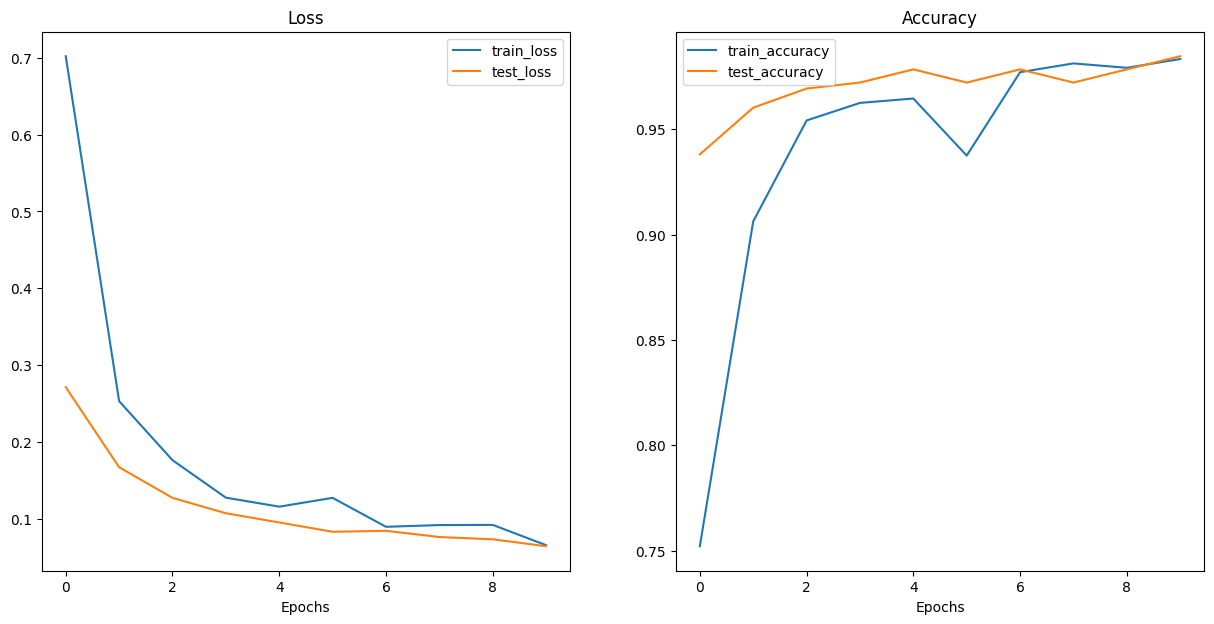

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

### 4.4 Saving ViT features extractor

In [ ]:
from going_modular import utils

utils.save_model(model = vit,
                 target_dir = 'models',
                 model_name = '09_pretrained_vit_features_extractor_pizza_steak_20_percent.pth')

[INFO] Saving model to: models/09_pretrained_vit_features_extractor_pizza_steak_20_percent.pth


### 4.5 Checking the size of ViT features extractor

In [ ]:
from pathlib import Path

pretrained_vit_model_size = Path('models/09_pretrained_vit_features_extractor_pizza_steak_20_percent.pth').stat().st_size//(1024*1024)
print(f"Pretrained ViT model size: {pretrained_vit_model_size} MB")

Pretrained ViT model size: 327 MB


### 4.6 Collecting ViT features extractor

In [ ]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [ ]:
effnetb2_total_params

7705221

In [ ]:
vit_stats = {
    "test_loss":vit_results['test_loss'][-1],
    "test_acc":vit_results['test_acc'][-1],
    "model_params":vit_total_params,
    "model_size (MB)": pretrained_vit_model_size
}
vit_stats

{'test_loss': 0.06443451717495918,
 'test_acc': 0.984659090909091,
 'model_params': 85800963,
 'model_size (MB)': 327}

## 5. Making predictions with model trained model and timming them

In [ ]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/204151.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/419962.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3486640.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3729167.jpg')]

### 5.1 Creating a function to make across the test dataset


In [ ]:
from typing import List, Dict
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm


def pred_and_store(
    paths: List[pathlib.Path],
    model: torch.nn.Module,
    transform: torchvision.transforms,
    class_names: List[str],
    device: str= 'cuda' if torch.cuda.is_available() else 'cpu'
) -> List[Dict]:
  pred_list = []

  # Loop through the target input path
  for path in tqdm(paths):

    # create an empty dictionary for each sample
    pred_dict = {}

    # set the sample path and ground truth class from the filepath
    pred_dict['image_path']=path
    class_name = path.parent.stem
    pred_dict['class_name']=class_name

    start_time = timer()

    # open the iamge using PIL
    img = Image.open(path)

    # transformxing the iamge
    transformed_image = transform(img).unsqueeze(0).to(device)

    # prepare the model for inference
    model = model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_dict['pred_class'] = class_names[pred_label.cpu()]  # python variable on cpu

      # add the pred + pred class to empty dictionary from step 4

      pred_dict['pred_prob']=round(pred_prob.unsqueeze(0).max().cpu().item(),4)
      end_time = timer()
      pred_dict['pred_time']=round(end_time-start_time,4)

    # see if th predicted class matches the ground truth class
    pred_dict['correct'] = pred_dict['pred_class'] == pred_dict['class_name']

    pred_list.append(pred_dict)
  return pred_list

### 5.2 Making and timing predction with EffNetB2

In [ ]:
# Make predtions test dataset with effnetB2
effnetb2_test_pred_dict = pred_and_store(paths = test_data_paths,
                                         model=effnetb2,
                                         transform=effnetb2_transforms,
                                         class_names=class_names,
                                         device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
effnetb2_test_pred_dict[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/204151.jpg'),
  'class_name': 'pizza',
  'pred_class': 'pizza',
  'pred_prob': 0.9356,
  'pred_time': 0.3411,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_class': 'pizza',
  'pred_prob': 0.4811,
  'pred_time': 0.1322,
  'correct': True}]

In [ ]:
# turn the test_pred_dict into dataframe
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dict)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_class,pred_prob,pred_time,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,pizza,0.9356,0.3411,True
1,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.4811,0.1322,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,steak,0.3678,0.1365,False
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.9772,0.1348,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.9497,0.1670,True


In [ ]:
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,143
False,7


In [ ]:
# Find the av time per predition
effnetb2_avg_time_per_pred = round(effnetb2_test_pred_df.pred_time.mean(),4)
print(f"Effnet avergage time per prediction: {effnetb2_avg_time_per_pred}")

Effnet avergage time per prediction: 0.1485


In [ ]:
effnetb2_stats['time_per_pred_cpu']=effnetb2_avg_time_per_pred

### 5.3 Making and timing preditions with ViT


In [ ]:
# Make list of prediction dictionaries with ViT features
vit_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                     model = vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/204151.jpg'),
  'class_name': 'pizza',
  'pred_class': 'pizza',
  'pred_prob': 0.9974,
  'pred_time': 2.2594,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_class': 'pizza',
  'pred_prob': 0.9957,
  'pred_time': 1.4834,
  'correct': True}]

In [ ]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_class,pred_prob,pred_time,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,pizza,0.9974,2.2594,True
1,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,pizza,0.9957,1.4834,True
2,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,pizza,0.9977,0.6655,True
3,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.9966,0.5958,True
4,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,pizza,0.9980,0.5581,True


In [ ]:
vit_test_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


In [ ]:
# Calaculate avg time per predction for ViT model
vit_avg_time_per_pred = round(vit_test_pred_df.pred_time.mean(),4)
print(f"ViT avergage time per prediction: {vit_avg_time_per_pred}")

ViT avergage time per prediction: 0.5227


In [ ]:
# Add avg time per prediction to ViT stats
vit_stats['time_per_pred_cpu']=vit_avg_time_per_pred

## 6 Comparing model results prediction time and size

In [ ]:
# turn stat dictionaries into dataframe
df = pd.DataFrame(data = [effnetb2_stats, vit_stats])

# Add column for model names
df['model']=['EffNetB2', 'ViT']

# Convert acc to percentage

df['test_acc']=round(df.test_acc*100,2)
df

,test_loss,test_acc,model_params,model_size (MB),time_per_pred_cpu,model
0,0.273147,95.62,7705221,29,0.1485,EffNetB2
1,0.064435,98.47,85800963,327,0.5227,ViT


Which model is better?
* `test_loss` ( lower is better) - Vit
* `test_acc` ( higher is better) - EffNetB2
* `model_params` ( lower is better) - EffNetB2
* `model_size (MB)` ( lower is better) - EffNetB2

### 6.1 Visualizing the speed VS Performance tradeoff

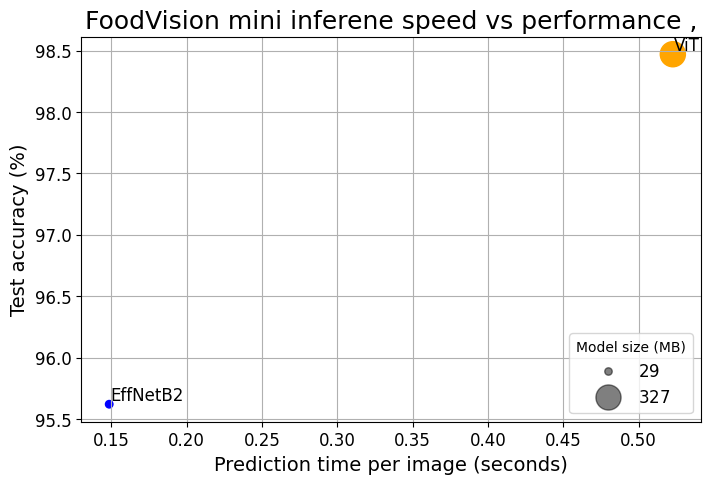

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))
scatter = ax.scatter(data=df,
                     x = 'time_per_pred_cpu',
                     y='test_acc',
                     c=['blue', 'orange'],
                     s='model_size (MB)')

# 2. Add titles and labels to make our plot look good
ax.set_title('FoodVision mini inferene speed vs performance ,', fontsize=18)
ax.set_xlabel('Prediction time per image (seconds)', fontsize=14)
ax.set_ylabel('Test accuracy (%)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)


for i, row in df.iterrows():
    ax.annotate(text=row['model'],
                xy=(row['time_per_pred_cpu']+0.0006, row['test_acc']+0.03),
                size=12)

handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend =ax.legend(handles, labels, loc = 'lower right',
          title = 'Model size (MB)',
          fontsize=12)

## 7. Bringin foodvision mini to live by creating a gradio demo

In [ ]:
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(f'gradio version: {gr.__version__}')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.0 MB/s eta 0:00:00
gradio version: 5.7.1


### 7.2  Create a function to map our input and outputs


In [ ]:
## put our model on the cpu

effnetb2 = effnetb2.to('cpu')

# check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:

  # start timer
  start_time = timer()
  # transform the input image
  img = effnetb2_transforms(img).unsqueeze(0)  # unsqeeze the add the batch dimesnion

  # put model into eval mode
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  #create prediction
  pred_labels_and_prob = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # end timer and calculate time
  end_time = timer()
  pred_time = round(end_time-start_time,4)

  return pred_labels_and_prob, pred_time

In [ ]:
import random
from PIL import Image


test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[0]


random_image_path = random.sample(test_data_paths, k=1)
img = Image.open(random_image_path[0])

print(f"[INFO] predicting on image at path: {random_image_path[0]}")
pred_dict, pred_time = predict(img=img)
print(pred_dict, pred_time)

[INFO] predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/3376617.jpg
{'pizza': 0.5717838406562805, 'steak': 0.08249225467443466, 'sushi': 0.3457238972187042} 0.0993


### 7.3 Creating a list of example images

In [ ]:
# Create list of example inputs to our gradio demo

example_list = [[str(filepath) for filepath in random.sample(test_data_paths, k=3)]]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg',
  'data/pizza_steak_sushi_20_percent/test/steak/1848936.jpg',
  'data/pizza_steak_sushi_20_percent/test/sushi/1944743.jpg']]

### 7.4 Build a gradio interfence

In [ ]:
import gradio as gr

title = 'FoodVision Mini'

description = "EffnetB2"
article = 'Pytorch model deployment'

# create the gradio demo

demo = gr.Interface(fn = predict,
                    inputs = gr.Image(type='pil'),
                    outputs = [gr.Label(num_top_classes=3,label='Predictions'),
                               gr.Number(label="Prediction time (s)")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article)
demo.launch(debug=False, share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c4a1aab93c4c2715e9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8.2 Deployed gradio file structures
colab -> folder with all in one folder-> upload the folder into huggingface
`demo/

### 8.3 create a demo folder to store our foodvision app files

In [ ]:
import shutil
from pathlib import Path

# create FoodVision mini demo path

foodvision_mini_demo_path = Path('demos/foodvision_mini')

# remove files that might exist and create a new directoy

if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

else:
  foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/foodvision_mini/

### 8.4 Create a filder of examples image to use with our foodvison mini

In [ ]:
import shutil
from pathlib import Path

# create a exmaple directory

foodvision_mini_examples_path = foodvision_mini_demo_path/'examples'
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)


foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
  Path('data/pizza_steak_sushi_20_percent/test/steak/1848936.jpg'),
  Path('data/pizza_steak_sushi_20_percent/test/sushi/1944743.jpg')]


# copy the three images to the example
for img_path in foodvision_mini_examples:
  destination_path = foodvision_mini_examples_path/img_path.name
  print(f"[INFO] Copying {img_path} to {destination_path}")
  shutil.copy2(src=img_path, dst=destination_path)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg to demos/foodvision_mini/examples/1067986.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/1848936.jpg to demos/foodvision_mini/examples/1848936.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/1944743.jpg to demos/foodvision_mini/examples/1944743.jpg


### 8.5 Moving our trained effnetb2 model into foodvision dir

In [ ]:
import shutil

effnetb2_foodvision_mini_model_path = 'models/09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth'

# destion matp
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path/effnetb2_foodvision_mini_model_path.split('/')[1]

try:
  print(f'[INFO] Moving {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}')
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_destination)
  print(f'[INFO] {effnetb2_foodvision_mini_model_path} moved to {effnetb2_foodvision_mini_model_destination}')
except:
  print(f"[INFO] {effnetb2_foodvision_mini_model_path} already moved")
  print(f'[INFO] {effnetb2_foodvision_mini_model_destination} already exists')



[INFO] Moving models/09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth
[INFO] models/09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth moved to demos/foodvision_mini/09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth


### 8.6 Truning off effnetb2 model into python script (model.py)

In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision
from torch import nn
def create_effnetb2_model(num_classes:int = 3,
                          seed:int = 42,
                          ):
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnetb2_transforms = effnetb2_weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = effnetb2_weights)
  for param in model.parameters():
    param.requires_grad = False


  torch.manual_seed(42)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  )
  return model, effnetb2_transforms

Overwriting demos/foodvision_mini/model.py


In [ ]:
from demos.foodvision_mini.model import create_effnetb2_model

### 8.7 Truing foodvison gradio app into python scripts

In [ ]:
%%writefile demos/foodvision_mini/app.py
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from typing import Tuple, Dict
from timeit import default_timer as timmer
from typing import Tuple, Dict

class_names = ['pizza','steak','sushi']

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3)

# loead save weights
effnetb2.load_state_dict(torch.load(
    f='foodvision_mini/09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth',
    map_location = torch.device('cpu')
                         )
      )

def predict(img) -> Tuple[Dict, float]:

  # start timer
  start_time = timer()
  # transform the input image
  img = effnetb2_transforms(img).unsqueeze(0)  # unsqeeze the add the batch dimesnion

  # put model into eval mode
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  #create prediction
  pred_labels_and_prob = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # end timer and calculate time
  end_time = timer()
  pred_time = round(end_time-start_time,4)

  return pred_labels_and_prob, pred_time

title = 'FoodVision Mini'

description = "EffnetB2"
article = 'Pytorch model deployment'

example_list = [['examples/'+example] for example in os.listdir('examples')]

# create the gradio demo

demo = gr.Interface(fn = predict,
                    inputs = gr.Image(type='pil'),
                    outputs = [gr.Label(num_top_classes=3,label='Predictions'),
                               gr.Number(label="Prediction time (s)")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article)
demo.launch(debug=False, share=True)

Writing demos/foodvision_mini/app.py


In [ ]:
example_list = [['examples/'+example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/1944743.jpg'], ['examples/1067986.jpg'], ['examples/1848936.jpg']]

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
gradio==5.7.1
torchvision==0.20.1
torch==2.5.1


Overwriting demos/foodvision_mini/requirements.txt


In [ ]:
torchvision.__version__

'0.20.1+cu121'

In [ ]:
torch.__version__

'2.5.1+cu121'

In [ ]:
gr.__version__

'5.7.1'

In [ ]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth  examples	__pycache__
app.py								      model.py	requirements.txt


In [ ]:
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x '*.pyc' '*__pycache__' '*.ipynb' '*ipynb_checkpoints*'

  adding: 09_pretrained_effnetb2_features_extractor_pizza_steak_20_percent.pth (deflated 8%)
  adding: app.py (deflated 55%)
  adding: examples/ (stored 0%)
  adding: examples/1944743.jpg (deflated 27%)
  adding: examples/1067986.jpg (deflated 1%)
  adding: examples/1848936.jpg (deflated 1%)
  adding: model.py (deflated 51%)
  adding: __pycache__/ (stored 0%)
  adding: requirements.txt (deflated 13%)


## 10. Foodvision Big

### 10.1 Creating a model for FoodVision Big + transformers

In [1]:
from torch import nn
import torch
import torchvision
def create_effnetb2_model(num_classes:int = 3,
                          seed:int = 42,
                          ):

  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnetb2_transforms = effnetb2_weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = effnetb2_weights)
  for param in model.parameters():
    param.requires_grad = False


  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  )
  return model, effnetb2_transforms

In [2]:
!pip install torchinfo

In [3]:
from torchinfo import summary
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)
summary(effnetb2_food101,
        input_size=(1,3,224,224),
        col_names = ['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:01<00:00, 36.6MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [4]:
# adding trivialAugment to existing transforms
food101_train_transforms = torchvision.transforms.Compose([
  torchvision.transforms.TrivialAugmentWide(),
  effnetb2_transforms
])
food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

### 10.2 Getting datasets

In [5]:
from torchvision import datasets
from pathlib import Path

data_dir = Path('data')
train_data = datasets.Food101(root=data_dir,
                               split='train',
                               transform=food101_train_transforms,
                               download=True)

test_data = datasets.Food101(root=data_dir,
                               split='test',
                               transform=effnetb2_transforms,
                               download=True)

100%|██████████| 5.00G/5.00G [03:59<00:00, 20.9MB/s]


Extracting data/food-101.tar.gz to data


In [6]:
# get food101 class names
class_names = train_data.classes
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 creating a subset of the food101 dataset for faster experiment


In [7]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  length_1 = int(len(dataset)*split_size)
  lenght_2 = len(dataset) - length_1
  print(f"[INFO] split dataset of lenght {len(dataset)} into split size: {length_1} and {lenght_2}")
  random_split_1, random_split_2 =random_split(dataset, [length_1, lenght_2], generator=torch.Generator().manual_seed(seed))
  return random_split_1, random_split_2


In [8]:
# creating training 20% split food101
train_data_food101_20_percent, _ = split_dataset(train_data, split_size=0.2)
test_data_food101_20_percent, _ = split_dataset(test_data, split_size=0.2)

[INFO] split dataset of lenght 75750 into split size: 15150 and 60600
[INFO] split dataset of lenght 25250 into split size: 5050 and 20200


In [9]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

### 10.4 Turning our food101 dataset into dataloader

In [10]:
import torch
import os

BATCH_SIZE=32

train_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    dataset=train_data_food101_20_percent,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count()
)

test_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    dataset=test_data_food101_20_percent,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=os.cpu_count()
)


In [11]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

### 10.5 Traning foodvision

In [12]:
try:
  from torchinfo import summary

except:
  print("[INFO] couldn't find torchinfo, installing it...")
  !pip install torchinfo
  from torchinfo import summary

try:
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  print("[INFO] couldn't find going_modular, installing it...")
  !git clone https://github.com/dileep9968/pytorch
  !mv pytorch/going_modular .
  !mv pytorch/helper_functions.py .
  !rm -rf pytorch
  from going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] couldn't find going_modular, installing it...
Cloning into 'pytorch'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 96 (delta 42), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (96/96), 11.95 MiB | 8.88 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [13]:
from going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
torch.cuda.manual_seed(42)

effnetb2_food101_result = engine.train(model = effnetb2_food101,
                                       train_dataloader=train_dataloader_food101_20_percent,
                                       test_dataloader = test_dataloader_food101_20_percent,
                                       optimizer = optimizer,
                                       loss_fn=loss_fn,
                                       epochs =5,
                                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6033 | train_acc: 0.2874 | test_loss: 2.7405 | test_acc: 0.4943
Epoch: 2 | train_loss: 2.8105 | train_acc: 0.4582 | test_loss: 2.4449 | test_acc: 0.5395
Epoch: 3 | train_loss: 2.5983 | train_acc: 0.5025 | test_loss: 2.3414 | test_acc: 0.5627
Epoch: 4 | train_loss: 2.4848 | train_acc: 0.5263 | test_loss: 2.2852 | test_acc: 0.5777
Epoch: 5 | train_loss: 2.4289 | train_acc: 0.5449 | test_loss: 2.2660 | test_acc: 0.5861


### 10.6 Inspecting loss curves of foodvision big model

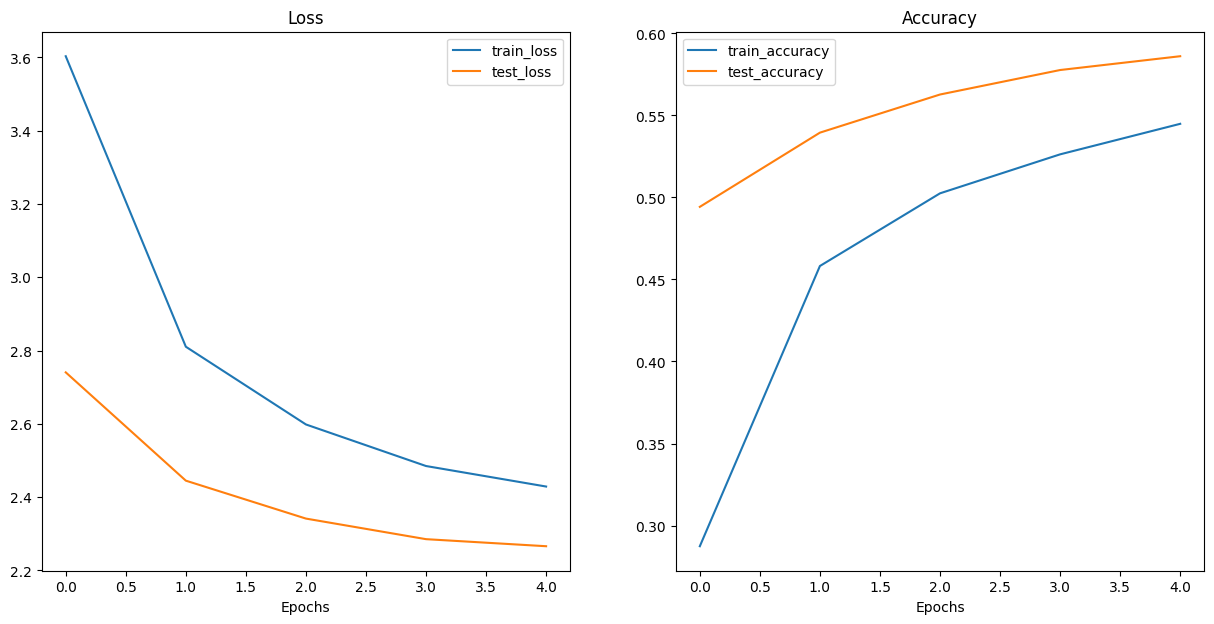

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_result)

### 10.7 Save and load foodvision big model

In [17]:
from going_modular import utils

effnetb2_food101_model_path = '09_pretrained_effnetb2_features_extractor_food101_20_percent.pth'

# Saving foodvision big model
utils.save_model(model = effnetb2_food101,
                 target_dir = 'models',
                 model_name = effnetb2_food101_model_path)

[INFO] Saving model to: models/09_pretrained_effnetb2_features_extractor_food101_20_percent.pth


In [18]:
# create food101 comptible effnetb2 instance
loaded_effnet2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

loaded_effnet2_food101.load_state_dict(torch.load(f'models/{effnetb2_food101_model_path}'))

<ipython-input-18-8149d4c9f0c0>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_effnet2_food101.load_state_dict(torch.load(f'models/{effnetb2_food101_model_path}'))


<All keys matched successfully>

### 10.8 Checking foodvision model size

In [19]:
from pathlib import Path

pretrained_effnetb2_model_size = Path('models/09_pretrained_effnetb2_features_extractor_food101_20_percent.pth').stat().st_size//(1024*1024)

print(f"[INFO] pretrained_effnetb2_model_size: {pretrained_effnetb2_model_size} MB")


[INFO] pretrained_effnetb2_model_size: 30 MB


## 11. Truning our foodvision big model into deplyoble app

In [14]:
from pathlib import Path

foodvision_mini_demo_path = Path('demos/foodvision_big/')

foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

(foodvision_mini_demo_path/'examples').mkdir(parents=True, exist_ok=True)

### 11.1 Download an example image and moving it to the example dir

In [23]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!mv 03-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpeg

In [24]:
!mv models/09_pretrained_effnetb2_features_extractor_food101_20_percent.pth demos/foodvision_big/

### 11.2 Saving food101 names to file (`class_names.txt`)

In [26]:
foodvision_big_class_names_path = foodvision_mini_demo_path/'class_names.txt'
foodvision_big_class_names_path


PosixPath('demos/foodvision_big/class_names.txt')

In [29]:
with open(foodvision_big_class_names_path, 'w') as f:
  f.write('\n'.join(class_names))

In [30]:
# Open food101 class names file and read each line into list
with open(foodvision_big_class_names_path, 'r') as f:
  food101_class_names_list = [food.strip() for food in f.readlines()]

### 11.3 Create foodvision_big model.py script

In [32]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision
from torch import nn
def create_effnetb2_model(num_classes:int = 101,
                          seed:int = 42,
                          ):
  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  effnetb2_transforms = effnetb2_weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = effnetb2_weights)
  for param in model.parameters():
    param.requires_grad = False


  torch.manual_seed(42)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes, bias=True)
  )
  return model, effnetb2_transforms


Writing demos/foodvision_big/model.py


### 11.4 Turing our foodvision big gradion app into app.py

In [33]:
%%writefile demos/foodvision_big/app.py
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from typing import Tuple, Dict
from timeit import default_timer as timmer
from typing import Tuple, Dict

with open('class_names.txt', 'r') as f:
  class_names = [food.strip() for food in f.readlines()]

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# loead save weights
effnetb2.load_state_dict(torch.load(
    f='09_pretrained_effnetb2_features_extractor_food101_20_percent.pth',
    map_location = torch.device('cpu')
                         )
      )

def predict(img) -> Tuple[Dict, float]:

  # start timer
  start_time = timmer()
  # transform the input image
  img = effnetb2_transforms(img).unsqueeze(0)  # unsqeeze the add the batch dimesnion

  # put model into eval mode
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  #create prediction
  pred_labels_and_prob = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # end timer and calculate time
  end_time = timmer()
  pred_time = round(end_time-start_time,4)

  return pred_labels_and_prob, pred_time

title = 'FoodVision Big'

description = "EffnetB2"
article = 'Pytorch model deployment'

example_list = [['examples/'+example] for example in os.listdir('examples')]

# create the gradio demo

demo = gr.Interface(fn = predict,
                    inputs = gr.Image(type='pil'),
                    outputs = [gr.Label(num_top_classes=5,label='Predictions'),
                               gr.Number(label="Prediction time (s)")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article)
demo.launch(debug=False)


Writing demos/foodvision_big/app.py


In [34]:
%%writefile demos/foodvision_big/requirements.txt
gradio==5.7.1
torchvision==0.20.1
torch==2.5.1

Writing demos/foodvision_big/requirements.txt


### 11.6 Download the foodvision big

In [35]:
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x '*.pyc' '*__pycache__' '*.ipynb' '*ipynb_checkpoints*'

  adding: 09_pretrained_effnetb2_features_extractor_food101_20_percent.pth (deflated 8%)
  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpeg (deflated 0%)
  adding: model.py (deflated 51%)
  adding: requirements.txt (deflated 13%)


In [40]:
try:
  from google.colab import files
  files.download('demos/foodvision_big/foodvision_big.zip')
except:
  print("[INFO] not running on google colab")

[INFO] not running on google colab


In [41]:
  from google.colab import files
  files.download('demos/foodvision_big/foodvision_big.zip')


FileNotFoundError: Cannot find file: demos/foodvision_big/foodvision_big.zip